In [18]:
# Import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
import scipy.linalg as LA

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

In [6]:
# Read the Data and Shuffle it 
from sklearn.datasets import fetch_olivetti_faces
from skimage.transform import rescale, resize
dataset = fetch_olivetti_faces(shuffle=True)
train_data  = dataset.data.astype(np.float64)
print('---- Before Centering -------')
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_data.mean(),train_data.std())

shuffle_index = np.random.permutation(len(train_data))
train_data = train_data[shuffle_index]

---- Before Centering -------
(400, 4096)
0.0 1.0
0.5470424729887565 0.17251528436417765


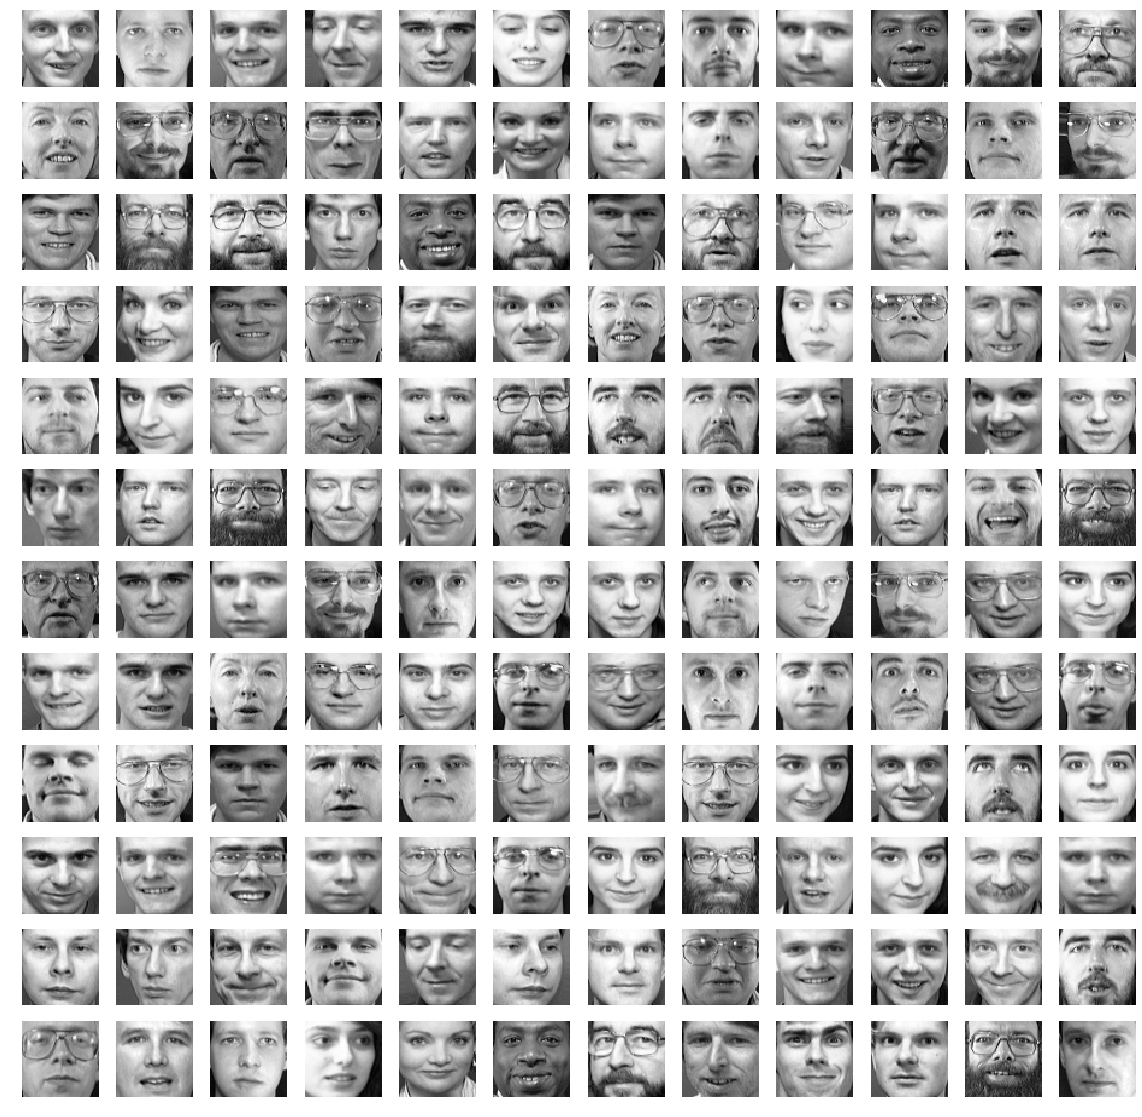

In [7]:
# view some of the data
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_data[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

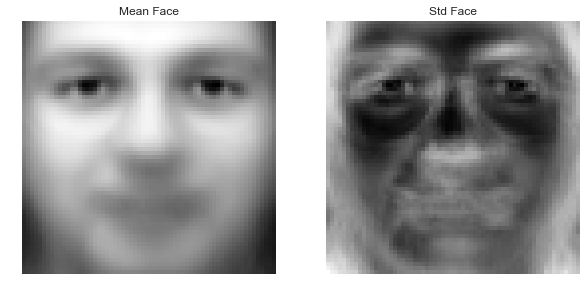

In [9]:
# center it per dimension
mean_face = train_data.mean(0); std_face = train_data.std(0)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(mean_face.reshape(64,64),cmap='gray')
plt.axis('off')
plt.title("Mean Face")

plt.subplot(122)
plt.imshow(std_face.reshape(64,64),cmap='gray')
plt.axis('off')
plt.title("Std Face")

plt.show()

---- Before Centering -------
(400, 4096)
-0.640640495447442 0.6372004163265228
-2.8796409701214996e-18 0.13880795800960016


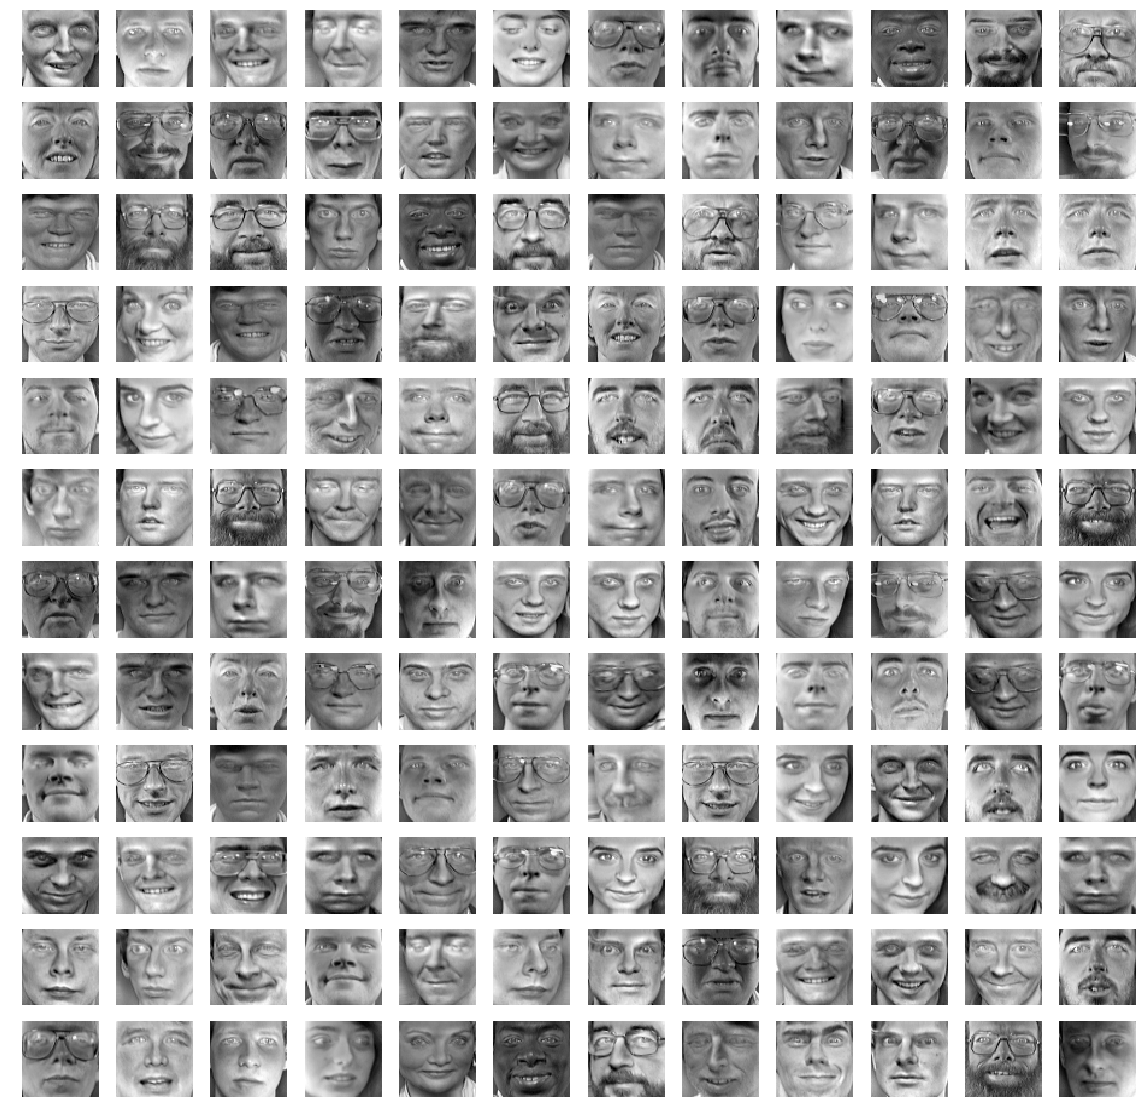

In [10]:
# center the face per dimesion and view it
centered = train_data - mean_face
print('---- After Centering -------')
print(centered.shape)
print(centered.min(),centered.max())
print(centered.mean(),centered.std())
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(centered[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

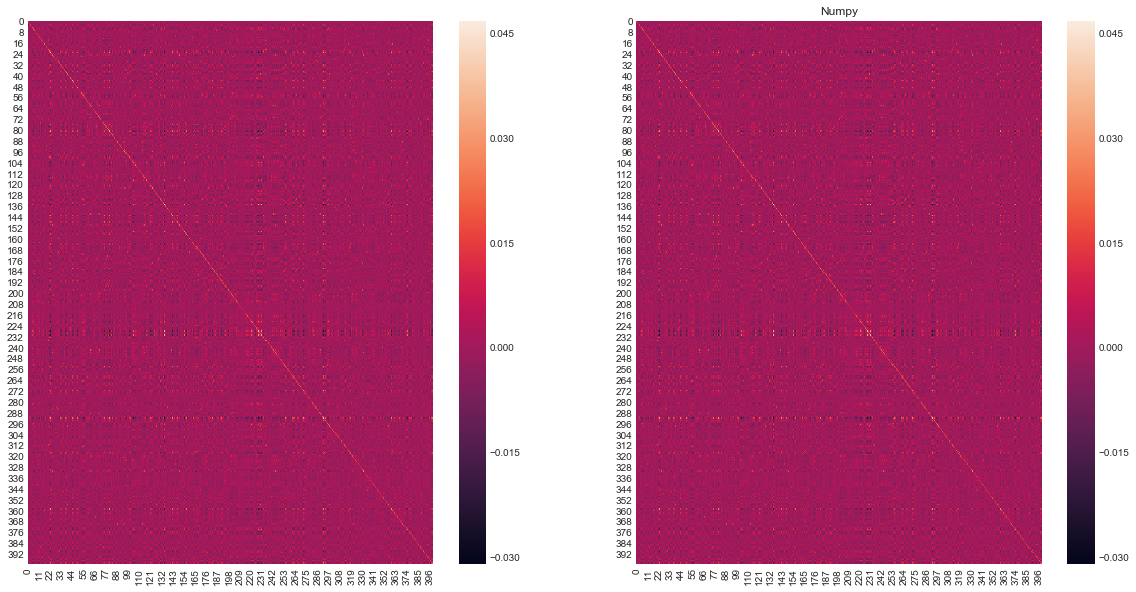

In [17]:
# calculate the co-variance 
centered_both = centered - centered.mean(1)[:,np.newaxis]
centered_both_cov = (centered_both @ centered_both.T)/centered_both.shape[1]
plt.figure(figsize=(20,10))
plt.title('Manual')
plt.subplot(121)
sns.heatmap(centered_both_cov)
plt.subplot(122)
plt.title('Numpy')
sns.heatmap(np.cov(centered,rowvar=True))
plt.show()

In [19]:
# Eigen value decomposition
evalue,evector = LA.eigh(centered_both_cov)

In [21]:
# sort the eigen values 
print('First 5 Values before sorting: ',evalue[:5])
print('Final 5 Values before sorting: ',evalue[-5:])
print('First 5 Vector Mean before sorting: ',evector[:,:5].mean())
print('Final 5 Vector Mean before sorting: ',evector[:,-5:].mean())
idx = np.argsort(evalue)[::-1]
print('-------------------------')
evalue_sort = evalue[idx]; evector_sort = evector[:,idx]
print('First 5 Values after sorting: ',evalue_sort[:5])
print('Final 5 Values after sorting: ',evalue_sort[-5:])
print('First 5 Vector Mean after sorting: ',evector_sort[:,:5].mean())
print('Final 5 Vector Mean after sorting: ',evector_sort[:,-5:].mean())

First 5 Values before sorting:  [1.83070021e-18 1.26254599e-04 1.54294092e-04 1.64793093e-04
 1.67680294e-04]
Final 5 Values before sorting:  [0.24658138 0.33915934 0.43051848 0.61670755 1.1001891 ]
First 5 Vector Mean before sorting:  0.010000000000000255
Final 5 Vector Mean before sorting:  8.881784197001253e-19
-------------------------
First 5 Values after sorting:  [1.1001891  0.61670755 0.43051848 0.33915934 0.24658138]
Final 5 Values after sorting:  [1.67680294e-04 1.64793093e-04 1.54294092e-04 1.26254599e-04
 1.83070021e-18]
First 5 Vector Mean after sorting:  3.191891195797325e-19
Final 5 Vector Mean after sorting:  0.010000000000000255


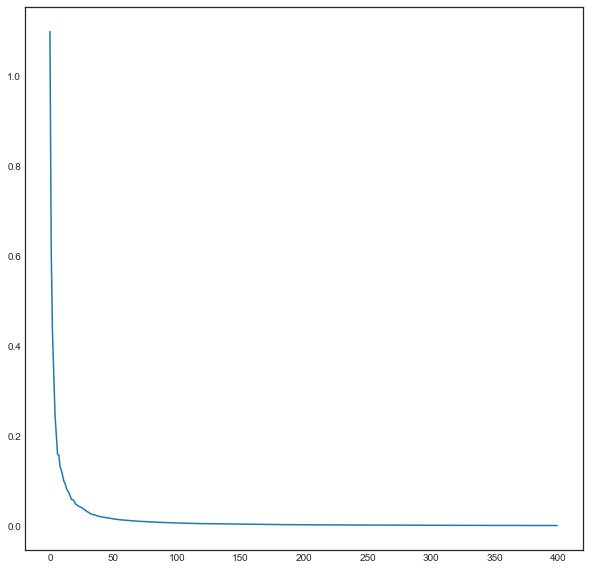

Original Eig Vector:  (400, 400)
Selected Eig Vector:  (400, 50)


In [25]:
# plot the variance of e value select 50 eigen vectors
plt.figure(figsize=(10,10))
plt.plot(evalue_sort)
plt.show()
evector_sort_small = evector_sort[:,:50]
print('Original Eig Vector: ',evector_sort.shape)
print('Selected Eig Vector: ',evector_sort_small.shape)

Reduced data Shape : (50, 4096)


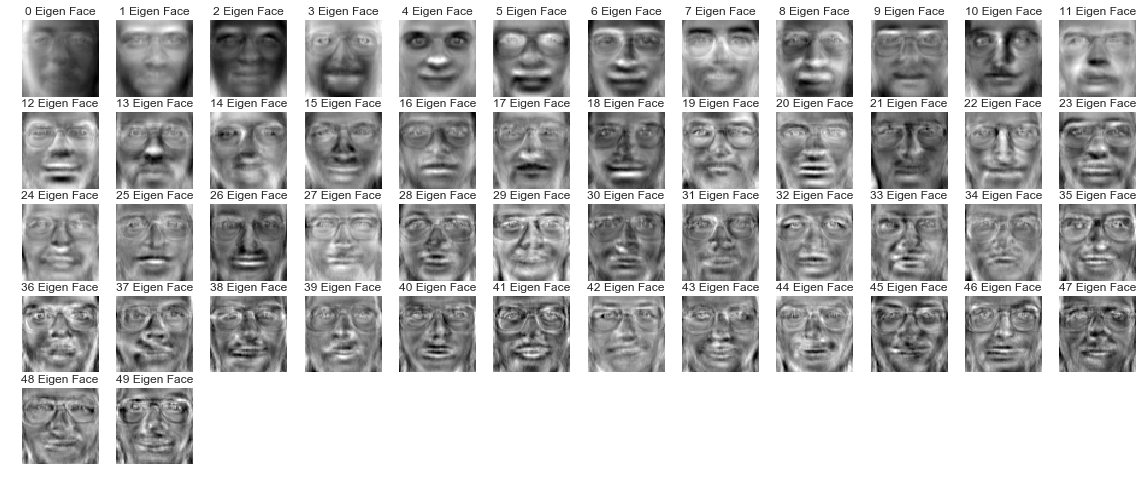

In [40]:
# project the normalized centered data to sub space
sub_centered = evector_sort_small.T @ centered_both
print('Reduced data Shape :',sub_centered.shape)
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    try: 
        sub_centered[i-1].all()
        fig.add_subplot(rows, columns, i)
        plt.imshow(sub_centered[i-1].reshape(64,64),cmap='gray')
        plt.axis('off')
        plt.title(str(i-1) + ' Eigen Face')
    except:
        pass
plt.show()

Reconstructed data Shape : (50, 4096)


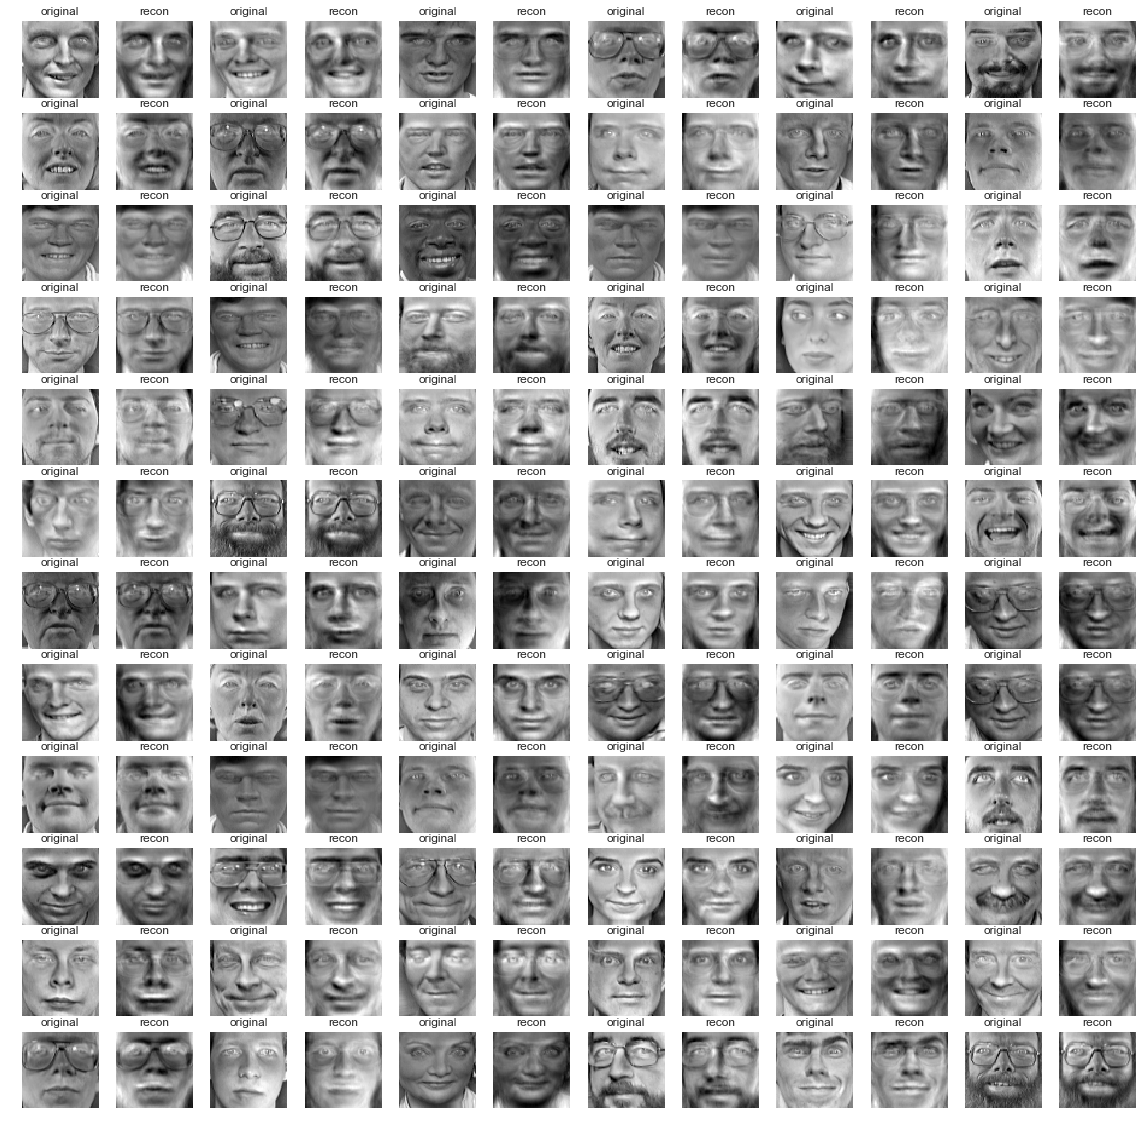

In [43]:
# Reconstruce form the small data
recon_data = evector_sort_small @ sub_centered
print('Reconstructed data Shape :',sub_centered.shape)
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if i % 2 == 0 :
        plt.title("recon")
        plt.imshow(recon_data[i-2].reshape(64,64),cmap='gray')
    else:
        plt.title("original")
        plt.imshow(centered_both[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

In [45]:
# Hyper Parameters
train_batch = sub_centered.copy()
num_epoch = 1000 ; learing_rate = 0.0001
beta1,beta2,adam_e = 0.9,0.999, 1e-8

In [78]:
# Define Class
def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FastICA_Layer():

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.005,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act
    
    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)
    
    def getw(self): return self.w
    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer
    
    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA * self.w
        grad_w_dec = self.sym_decorrelation(grad_w)
        update_w = []
        update_w.append(tf.assign(self.w,grad_w_dec))
        return update_w

In [83]:
# Define graph
x = tf.placeholder(shape=[50,4096],dtype=tf.float64)

fast_ica_layer = FastICA_Layer(50,50,tf_logcosh,d_tf_logcosh)
fica = fast_ica_layer.feedforward(x)
fica_w_update = fast_ica_layer.backprop_ica()

In [84]:
# Define Session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for iter in range(num_epoch):
    sess_results = sess.run([fica,fica_w_update],feed_dict={x:sub_centered})
    print('Iter: ',iter,' mean fica: ',sess_results[0].mean())

Iter:  0  mean fica:  4.597017211338539e-19
Iter:  1  mean fica:  5.204170427930421e-19
Iter:  2  mean fica:  -1.3270634591222575e-18
Iter:  3  mean fica:  1.2056328158038808e-18
Iter:  4  mean fica:  2.9490299091605723e-19
Iter:  5  mean fica:  -1.3877787807814457e-19
Iter:  6  mean fica:  7.979727989493313e-19
Iter:  7  mean fica:  3.2959746043559335e-19
Iter:  8  mean fica:  4.597017211338539e-19
Iter:  9  mean fica:  6.028164079019404e-19
Iter:  10  mean fica:  3.0791341698588324e-19
Iter:  11  mean fica:  1.2967057982926634e-18
Iter:  12  mean fica:  2.47198095326695e-19
Iter:  13  mean fica:  1.0668549377257363e-18
Iter:  14  mean fica:  -2.285498179599443e-18
Iter:  15  mean fica:  -6.505213034913027e-19
Iter:  16  mean fica:  -1.4224732503009817e-18
Iter:  17  mean fica:  -5.204170427930421e-19
Iter:  18  mean fica:  -1.2576745200831851e-18
Iter:  19  mean fica:  -1.188285581044113e-18
Iter:  20  mean fica:  -1.6479873021779667e-18
Iter:  21  mean fica:  -4.163336342344337e-18


Iter:  176  mean fica:  -1.46150452851046e-18
Iter:  177  mean fica:  -7.41594285980085e-19
Iter:  178  mean fica:  -1.4181364416110398e-18
Iter:  179  mean fica:  -1.4007892068512717e-18
Iter:  180  mean fica:  -2.914335439641036e-18
Iter:  181  mean fica:  -1.1102230246251566e-18
Iter:  182  mean fica:  -2.905661822261152e-19
Iter:  183  mean fica:  -1.964574336543734e-18
Iter:  184  mean fica:  -8.803721640582295e-19
Iter:  185  mean fica:  -1.5569143196891843e-18
Iter:  186  mean fica:  -8.933825901280557e-19
Iter:  187  mean fica:  -3.035766082959412e-19
Iter:  188  mean fica:  -2.5717275531356164e-18
Iter:  189  mean fica:  -9.324138683375338e-19
Iter:  190  mean fica:  -1.8821749714348356e-18
Iter:  191  mean fica:  -2.0383000842727482e-19
Iter:  192  mean fica:  -1.8648277366750676e-19
Iter:  193  mean fica:  -1.756407519426517e-18
Iter:  194  mean fica:  -1.5178830414797062e-18
Iter:  195  mean fica:  -5.507747036226363e-19
Iter:  196  mean fica:  -8.370040771588094e-19
Iter: 

Iter:  350  mean fica:  -7.37257477290143e-19
Iter:  351  mean fica:  -7.372574772901431e-20
Iter:  352  mean fica:  -2.3201926491189793e-18
Iter:  353  mean fica:  -9.58434720477186e-19
Iter:  354  mean fica:  -1.2880321809127794e-18
Iter:  355  mean fica:  -2.732189474663471e-18
Iter:  356  mean fica:  4.380176776841438e-19
Iter:  357  mean fica:  -1.4094628242311558e-18
Iter:  358  mean fica:  3.0791341698588324e-19
Iter:  359  mean fica:  -1.3227266504323153e-18
Iter:  360  mean fica:  -1.6089560239684886e-18
Iter:  361  mean fica:  -1.2620113287731272e-18
Iter:  362  mean fica:  -5.724587470723464e-19
Iter:  363  mean fica:  -2.0383000842727484e-18
Iter:  364  mean fica:  -2.918672248330978e-18
Iter:  365  mean fica:  -1.5395670849294162e-18
Iter:  366  mean fica:  -6.591949208711867e-19
Iter:  367  mean fica:  -1.8648277366750675e-18
Iter:  368  mean fica:  -1.916869440954372e-18
Iter:  369  mean fica:  1.6479873021779668e-19
Iter:  370  mean fica:  -7.676151381197371e-19
Iter:  

Iter:  525  mean fica:  -1.6566609195578507e-18
Iter:  526  mean fica:  -2.38524477946811e-19
Iter:  527  mean fica:  -1.3010426069826053e-18
Iter:  528  mean fica:  -5.854691731421724e-19
Iter:  529  mean fica:  -6.722053469410128e-19
Iter:  530  mean fica:  -6.505213034913027e-19
Iter:  531  mean fica:  -1.739060284666749e-18
Iter:  532  mean fica:  -1.7303866672868652e-18
Iter:  533  mean fica:  -1.986258379993444e-18
Iter:  534  mean fica:  -1.8778381627448937e-18
Iter:  535  mean fica:  6.461844948013606e-19
Iter:  536  mean fica:  -9.93129189996722e-19
Iter:  537  mean fica:  -2.2898349882893855e-18
Iter:  538  mean fica:  -2.2508037100799074e-18
Iter:  539  mean fica:  -9.80118763926896e-19
Iter:  540  mean fica:  6.461844948013606e-19
Iter:  541  mean fica:  -6.201636426617085e-19
Iter:  542  mean fica:  -1.0842021724855044e-18
Iter:  543  mean fica:  -3.903127820947816e-19
Iter:  544  mean fica:  -2.476317761956892e-18
Iter:  545  mean fica:  -1.960237527853792e-18
Iter:  546 

Iter:  700  mean fica:  -4.85722573273506e-19
Iter:  701  mean fica:  -2.0816681711721684e-18
Iter:  702  mean fica:  -1.3834419720915036e-18
Iter:  703  mean fica:  -1.48318857196017e-18
Iter:  704  mean fica:  -1.1405806854547506e-18
Iter:  705  mean fica:  -2.398255205537936e-18
Iter:  706  mean fica:  -1.1319070680748666e-18
Iter:  707  mean fica:  -1.9992688060632703e-18
Iter:  708  mean fica:  -5.941427905220565e-19
Iter:  709  mean fica:  -2.5804011705155006e-18
Iter:  710  mean fica:  -1.3444106938820255e-19
Iter:  711  mean fica:  -4.163336342344337e-19
Iter:  712  mean fica:  -1.2706849461530113e-18
Iter:  713  mean fica:  -1.5482407023093003e-18
Iter:  714  mean fica:  -2.3505503099485736e-18
Iter:  715  mean fica:  -1.6696713456276769e-18
Iter:  716  mean fica:  -1.8778381627448937e-18
Iter:  717  mean fica:  -6.505213034913026e-20
Iter:  718  mean fica:  -1.257674520083185e-19
Iter:  719  mean fica:  -8.630249292984615e-19
Iter:  720  mean fica:  4.81385764583564e-19
Iter:

Iter:  878  mean fica:  -2.2334564753201393e-18
Iter:  879  mean fica:  -8.456776945386934e-19
Iter:  880  mean fica:  -7.32920668600201e-19
Iter:  881  mean fica:  -2.458970527197124e-18
Iter:  882  mean fica:  -2.8753041614315577e-18
Iter:  883  mean fica:  -1.1188966420050406e-18
Iter:  884  mean fica:  -1.1102230246251566e-18
Iter:  885  mean fica:  -3.2526065174565133e-19
Iter:  886  mean fica:  -1.3660947373317355e-18
Iter:  887  mean fica:  -7.546047120499111e-19
Iter:  888  mean fica:  -7.155734338404329e-19
Iter:  889  mean fica:  -1.6523241108679088e-18
Iter:  890  mean fica:  -1.6653345369377347e-18
Iter:  891  mean fica:  -1.222980050563649e-18
Iter:  892  mean fica:  -1.6349768761081407e-18
Iter:  893  mean fica:  -8.023096076392733e-19
Iter:  894  mean fica:  -2.0643209364124003e-18
Iter:  895  mean fica:  6.895525817007809e-19
Iter:  896  mean fica:  -8.716985466783455e-19
Iter:  897  mean fica:  -1.5612511283791264e-18
Iter:  898  mean fica:  -2.38524477946811e-19
Iter:

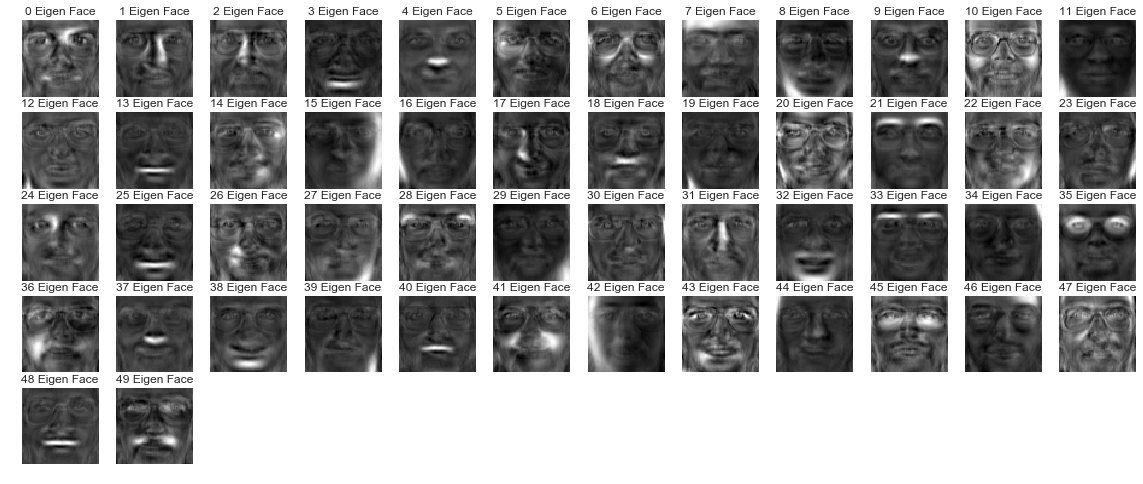

In [86]:
# view the indepedent images
resulted_images = sess.run(fica,feed_dict={x:sub_centered})
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    try: 
        sub_centered[i-1].all()
        fig.add_subplot(rows, columns, i)
        plt.imshow(resulted_images[i-1].reshape(64,64),cmap='gray')
        plt.axis('off')
        plt.title(str(i-1) + ' Eigen Face')
    except:
        pass
plt.show()